In [1]:
##############################################################################################################
#                       Kaggle Depression Dataset Competition: Classification Machine Learning Models
#                       (c) Dr. Serkan Kaya - 01 February 2025, All rights reserved
###############################################################################################################
#   Business Problem:
# A Comprehensive Dataset for Analyzing Health, Lifestyle, and Socio-Economic Fact.
# This dataset contains information on individuals with various attributes related to their personal and lifestyle factors.
# It is designed to facilitate analysis in areas such as health, lifestyle, and socio-economic status.
###############################################################################################################

In [2]:
#!pip install lightgbm

In [3]:
#!pip install xgboost

In [4]:
#!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)

In [2]:
print(pd.__version__) ## pandas 2.2.2
print(sns.__version__) ## seaborn 0.13.2

2.2.2
0.13.2


In [2]:
df = pd.read_csv('depression_data.csv', low_memory=False)

In [3]:
df.shape

(413768, 16)

In [5]:
df.head(2)

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes


In [6]:
df['History of Mental Illness'].value_counts() ### Target variable

#### Distribution of the classes in the Target Variable ####
# No (Negative class): 287,943 cases (69.6%)
# Yes (Positive class): 125,825 cases (30.4%)


History of Mental Illness
No     287943
Yes    125825
Name: count, dtype: int64

In [7]:
############################################################################################
#                      Exploratory Data Analysis (E.D.A.)
############################################################################################
#   STEP 1 - EDA : General View of the Dataset
############################################################################################

def check_df(dataframe, head=5):
    print('#################### Shape #########################')
    print(dataframe.shape)
    print('#################### Type ##########################')
    print(dataframe.dtypes)
    print('#################### Head #########################')
    print(dataframe.head(head))
    print('##################### Tail #########################')
    print(dataframe.tail(head))
    print('###################### NA ########################')
    print(dataframe.isnull().sum())
    print('###################### Quantile ########################')
    numeric_cols = dataframe.select_dtypes(include=['number'])
    print('###################### Quantile ########################')
    print(numeric_cols.quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_df(df) # General view of the dataset

# 'check_df' function shows the followings:
# There are 413768 observations and 16 variables (features)
# Data type of each variable (or feature)
# Head and tail of the dataset
# Nbr of missing values for each variable
# Distribution of each variable in the dataset along the quantiles

#################### Shape #########################
(413768, 16)
#################### Type ##########################
Name                             object
Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness        object
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object
#################### Head #########################
               Name  Age Marital Status    Education Level  \
0  Christine Barker   31        Married  Bachelor's Degree   
1  Jacqueline Lewis   55        Married        High

In [4]:
############################################################################################
#   STEP 2 - EDA : Finding numerical and categorical variables
############################################################################################

def grab_col_names(dataframe, cat_th=3, car_th=20):    
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Nbr of class threshold value for variables having numerical appearance but they are categorical variables (numerically encoded)
        car_th: int, optional
                Nbr of class threshold for categorical variables but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variants with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car + num_but_cat = total variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["O", "category"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes not in ["O", "category"]]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes in ["O", "category"]]

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes not in ["O", "category"]]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat

# See the detailed docstring in the function above for the information about the parameters of the funcion.

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
print('\n')
print('Categorical variables => {}' .format(cat_cols),'\n')
print('Numerical variables => {}' .format(num_cols),'\n')
print('Categorical but cardinal variables => {}' .format(cat_but_car),'\n')
print('Numerical but categorical variables => {}' .format(num_but_cat))

Observations: 413768
Variables: 16
cat_cols: 12
num_cols: 3
cat_but_car: 1
num_but_cat: 0


Categorical variables => ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Mental Illness', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions'] 

Numerical variables => ['Age', 'Number of Children', 'Income'] 

Categorical but cardinal variables => ['Name'] 

Numerical but categorical variables => []


                Marital Status   Count      Ratio
Marital Status                                   
Married                         240444  58.110825
Single                           72110  17.427641
Widowed                          68485  16.551546
Divorced                         32729   7.909988
##########################################


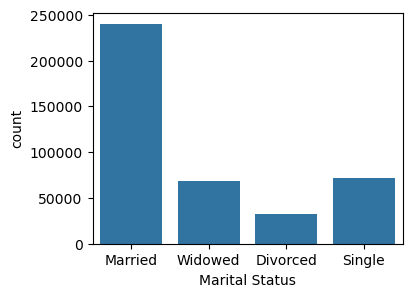

                   Education Level   Count      Ratio
Education Level                                      
Bachelor's Degree                   124329  30.047998
High School                         118927  28.742435
Associate Degree                     79999  19.334265
Master's Degree                      73768  17.828348
PhD                                  16745   4.046954
##########################################


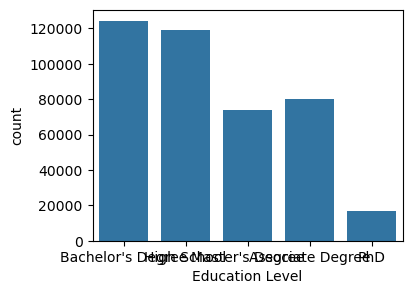

                Smoking Status   Count      Ratio
Smoking Status                                   
Non-smoker                      247416  59.795828
Former                          116184  28.079503
Current                          50168  12.124669
##########################################


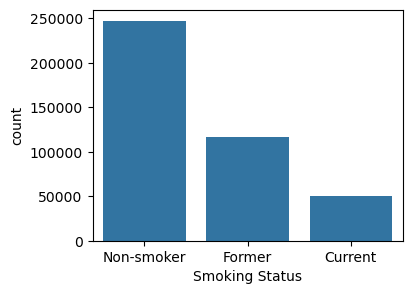

                         Physical Activity Level   Count      Ratio
Physical Activity Level                                            
Sedentary                                         176850  42.741343
Moderate                                          158013  38.188792
Active                                             78905  19.069865
##########################################


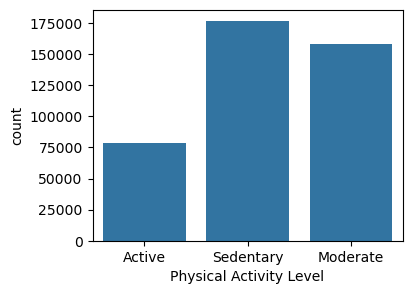

                   Employment Status   Count     Ratio
Employment Status                                     
Employed                              265659  64.20482
Unemployed                            148109  35.79518
##########################################


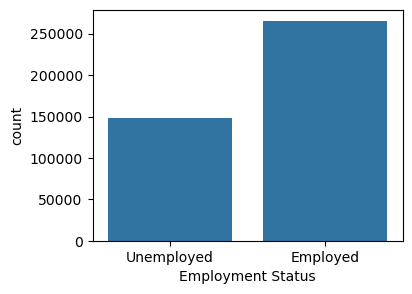

                     Alcohol Consumption   Count      Ratio
Alcohol Consumption                                        
Moderate                                  173440  41.917210
Low                                       139250  33.654125
High                                      101078  24.428665
##########################################


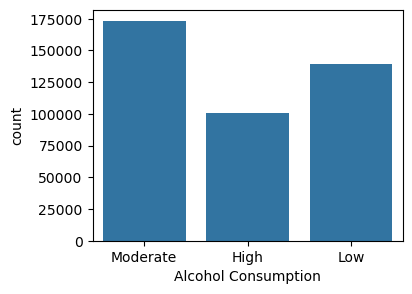

                Dietary Habits   Count      Ratio
Dietary Habits                                   
Unhealthy                       170817  41.283280
Moderate                        170446  41.193616
Healthy                          72505  17.523105
##########################################


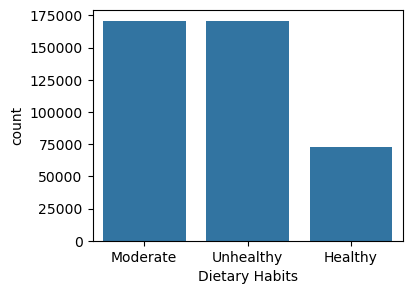

                Sleep Patterns   Count      Ratio
Sleep Patterns                                   
Fair                            196789  47.560227
Poor                            129582  31.317550
Good                             87397  21.122223
##########################################


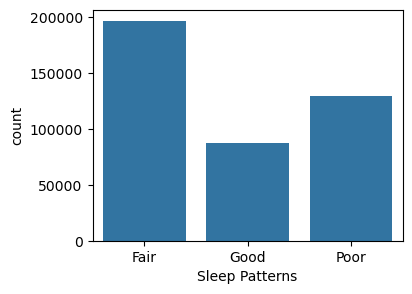

                           History of Mental Illness   Count      Ratio
History of Mental Illness                                              
No                                                    287943  69.590447
Yes                                                   125825  30.409553
##########################################


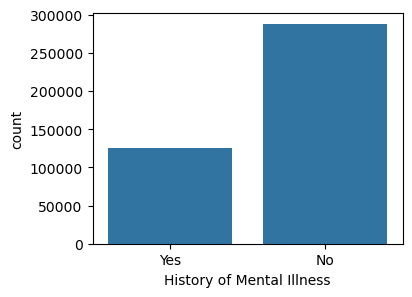

                            History of Substance Abuse   Count      Ratio
History of Substance Abuse                                               
No                                                      284880  68.850177
Yes                                                     128888  31.149823
##########################################


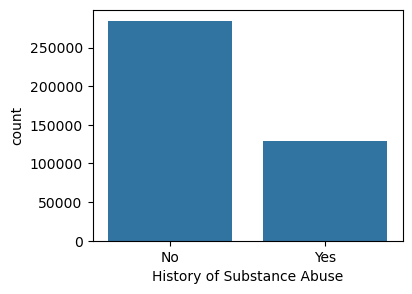

                              Family History of Depression   Count      Ratio
Family History of Depression                                                 
No                                                          302515  73.112227
Yes                                                         111253  26.887773
##########################################


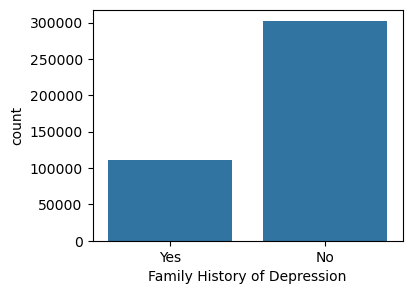

                            Chronic Medical Conditions   Count      Ratio
Chronic Medical Conditions                                               
No                                                      277561  67.081311
Yes                                                     136207  32.918689
##########################################


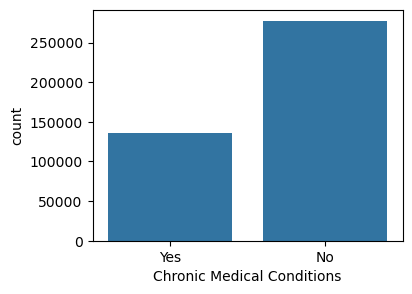

In [9]:
############################################################################################
#   STEP 3a - EDA : Perform an analysis of categorical variables.
############################################################################################

########### For df training dataset #############

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name+'   '+'Count': dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        plt.figure(figsize=(4, 3))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        plt.close()

########### For df training dataset #############

for i in cat_cols:  
    cat_summary(df, i, plot=True)  # We summarise categorical variables within themselves.

                       count          mean           std    min       5%     10%        20%        30%        40%        50%        60%        70%        80%         90%         95%         99%        max
Age                 413768.0     49.000713     18.158759  18.00    21.00    24.0     30.000     36.000     43.000     49.000     55.000     62.000     68.000      74.000      77.000      80.000      80.00
Number of Children  413768.0      1.298972      1.237054   0.00     0.00     0.0      0.000      0.000      1.000      1.000      2.000      2.000      3.000       3.000       3.000       4.000       4.00
Income              413768.0  50661.707971  40624.100565   0.41  4207.07  8428.4  16819.332  24059.472  28994.402  37520.135  47589.584  64369.008  86881.288  106816.921  134446.411  169723.038  209995.22


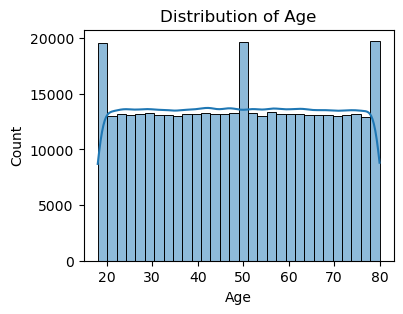

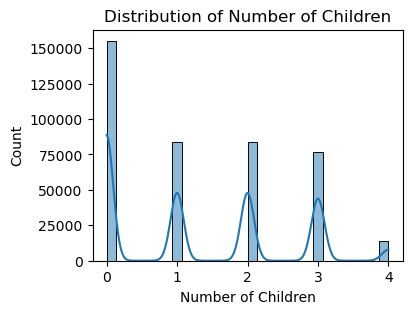

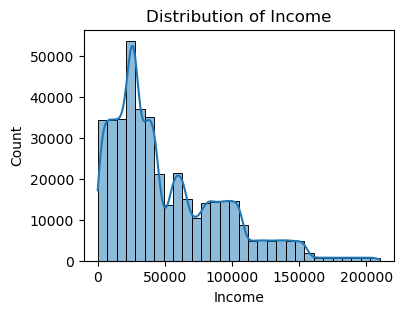

In [10]:
############################################################################################
#   STEP 3b - EDA :  Perform an analysis of numerical variables
############################################################################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    
    summary = dataframe[numerical_col].describe(quantiles).T  
    print(summary.to_string(index=True))
    
    if plot:
        for col in numerical_col:
            plt.figure(figsize=(4, 3)) 
            sns.histplot(data=dataframe[col], bins=30, kde=True)
            plt.xlabel(col)
            plt.title(f'Distribution of {col}')  
            plt.show()
            plt.close()

num_summary(df, num_cols, plot=True)

In [12]:
##### ANALYSIS on THE OUTPUT RESULTS Based on the distribution of numerical columns above #####

## 'Age' column:
#----------------
# This distribution appears relatively uniform with some spikes at certain ages (20, 50, and 80)
# The distribution doesn't show significant skewness
# No transformation needs as it's fairly well-distributed


## 'Number of Children' column:
#----------------
# This is a discrete distribution showing clear peaks at 0, 1, 2, and 3 children
# While it's not symmetrical, this is a natural distribution for count data
# No transformation needed since:
# a) It's categorical/count data by nature
# b) Machine learning algorithms can handle this type of discrete distribution well

## 'Income' column:
#-------------------
# Shows clear right-skewed (positive skew) distribution
# Many people in lower income brackets with a long tail towards higher incomes
# We can apply log transformation to this column (Note: This only would be helpful for distance-based algorithms (KNN, neural networks etc)


In [11]:
############################################################################################
#   STEP 4 - EDA : Perform an analysis of outliers
############################################################################################
# We will check outlier in the numerical variables (or columns). I have chosen q1=0.05 and q3=0.95

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None)

for col in num_cols:
    if col != 'History of Mental Illness':
        print(col, check_outlier(df, col))


Age False
Number of Children False
Income False


In [12]:
############################################################################################
#   STEP 5 - EDA : Make an analysis of missing values
############################################################################################

def missing_value_summary(df):
    missing_count = df.isna().sum()  
    missing_ratio = missing_count / len(df) 
    summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Ratio': missing_ratio
    }).sort_values(by='Missing Count', ascending=False)
    
    summary = summary[summary['Missing Count'] > 0]
    return summary

## Missing values in training dataset df
summary_df = missing_value_summary(df)
summary_df

,Missing Count,Missing Ratio


In [5]:
############################################################################################
#                           Feature Engineering
############################################################################################
#   STEP 6 - Feature Engineering : Removing/Dropping off some features
############################################################################################
# We need to drop 'Name' column/feature as it does not have any valuable information (it is a non-informative column)

df.drop('Name', axis=1, inplace=True)

In [6]:
df.shape

(413768, 15)

In [7]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 413768
Variables: 15
cat_cols: 12
num_cols: 3
cat_but_car: 0
num_but_cat: 0


In [8]:
############################################################################################
#   STEP 7 - Feature Engineering : Creating New Features
############################################################################################

In [9]:
df.shape ## (413768, 15)

(413768, 15)

In [10]:
def create_new_features(df):

    df_new = df.copy()
    
    # 1. Age-related features
    age_bins = [0, 25, 35, 50, 65, 100]
    age_labels = ['18-25', '26-35', '36-50', '51-65', '65+']
    df_new['age_group'] = pd.cut(df_new['Age'], bins=age_bins, labels=age_labels)
    df_new['is_retirement_age'] = (df_new['Age'] >= 65).astype(int)
    
    # Create life stage combining age group and marital status
    df_new['life_stage'] = df_new.apply(
        lambda x: f"{x['age_group']}_{x['Marital Status']}",
        axis=1
    )
    
    # 2. Income-based features
    df_new['income_per_family_member'] = df_new['Income'] / (df_new['Number of Children'] + 1)
    
    # Income brackets (example thresholds - adjust based on actual distribution)
    income_bins = [0, 15000, 30000, 50000, 75000, float('inf')]
    income_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    df_new['income_bracket'] = pd.cut(df_new['Income'], bins=income_bins, labels=income_labels)
    
    # 3. Health behavior score
    # Convert categorical variables to numeric scores
    activity_map = {
        'Sedentary': 0,
        'Moderate': 1,
        'Active': 2
    }
    
    diet_map = {
        'Unhealthy': 0,
        'Moderate': 1,
        'Healthy': 2
    }
    
    sleep_map = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2
    }
    
    smoking_map = {
        'Non-smoker': 0,
        'Former': 1,
        'Current': 2
    }
    
    alcohol_map = {
        'Low': 0,
        'Moderate': 1,
        'High': 2
    }
    
    df_new['physical_activity_score'] = df_new['Physical Activity Level'].map(activity_map)
    df_new['diet_score'] = df_new['Dietary Habits'].map(diet_map)
    df_new['sleep_score'] = df_new['Sleep Patterns'].map(sleep_map)
    df_new['smoking_score'] = df_new['Smoking Status'].map(smoking_map)
    df_new['alcohol_score'] = df_new['Alcohol Consumption'].map(alcohol_map)
    
    # Create composite health score (0-10)
    df_new['health_behavior_score'] = (
        df_new['physical_activity_score'] + 
        df_new['diet_score'] + 
        df_new['sleep_score'] + 
        (2 - df_new['smoking_score']) +  # Inverse smoking score
        (2 - df_new['alcohol_score'])    # Inverse alcohol score
    )
    
    # 4. Social support indicators
    # Family support based on marital status and children
    df_new['has_family_support'] = (
        (df_new['Marital Status'] == 'Married') | 
        (df_new['Number of Children'] > 0)
    ).astype(int)
    
    df_new['living_alone'] = (
        (df_new['Marital Status'].isin(['Single', 'Divorced', 'Widowed'])) & 
        (df_new['Number of Children'] == 0)
    ).astype(int)
    
    # 5. Stress factor combinations
    # Education to years mapping
    education_years_map = {
        'High School': 12,
        'Associate Degree': 14,
        "Bachelor's Degree": 16,
        "Master's Degree": 18,
        'PhD': 22
    }
    df_new['education_years'] = df_new['Education Level'].map(education_years_map)
    
    # Employment stress indicator
    df_new['employment_stress'] = (
        (df_new['Employment Status'] == 'Unemployed') & 
        (df_new['education_years'] >= 16)  # Higher education but unemployed
    ).astype(int)
    
    # Financial stress indicator
    df_new['financial_stress'] = (
        (df_new['Income'] < df_new['Income'].median()) & 
        (df_new['Number of Children'] > 0) &
        (df_new['Employment Status'] == 'Unemployed')
    ).astype(int)
    
    # 6. Risk factors and medical history
    # Count of medical/psychological risk factors
    df_new['risk_factor_count'] = (
        (df_new['Chronic Medical Conditions'] == 'Yes').astype(int) +
        (df_new['History of Substance Abuse'] == 'Yes').astype(int) +
        (df_new['Family History of Depression'] == 'Yes').astype(int)
    )
    
    # Overall health risk score
    df_new['health_risk_score'] = (
        (df_new['Chronic Medical Conditions'] == 'Yes').astype(int) * 2 +
        (df_new['Alcohol Consumption'] == 'High').astype(int) +
        (df_new['Smoking Status'] == 'Current').astype(int) +
        (df_new['Dietary Habits'] == 'Unhealthy').astype(int) +
        (df_new['Sleep Patterns'] == 'Poor').astype(int) +
        (df_new['Physical Activity Level'] == 'Sedentary').astype(int)
    )
    
    # 7. Lifestyle consistency
    df_new['lifestyle_consistency'] = (
        (df_new['physical_activity_score'] >= 1) & 
        (df_new['diet_score'] >= 1) & 
        (df_new['sleep_score'] >= 1) &
        (df_new['smoking_score'] <= 1) &    # Non-smoker or former smoker
        (df_new['alcohol_score'] <= 1)      # Low or moderate alcohol consumption
    ).astype(int)
    
    # 8. Combined psychological risk
    df_new['psychological_risk'] = (
        (df_new['Family History of Depression'] == 'Yes').astype(int) +
        (df_new['History of Substance Abuse'] == 'Yes').astype(int) +
        df_new['living_alone'] +
        (df_new['employment_stress']) +
        (df_new['Sleep Patterns'] == 'Poor').astype(int)
    )
    
    return df_new

In [11]:
df = create_new_features(df)

In [12]:
df.shape

(413768, 35)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Age                           413768 non-null  int64   
 1   Marital Status                413768 non-null  object  
 2   Education Level               413768 non-null  object  
 3   Number of Children            413768 non-null  int64   
 4   Smoking Status                413768 non-null  object  
 5   Physical Activity Level       413768 non-null  object  
 6   Employment Status             413768 non-null  object  
 7   Income                        413768 non-null  float64 
 8   Alcohol Consumption           413768 non-null  object  
 9   Dietary Habits                413768 non-null  object  
 10  Sleep Patterns                413768 non-null  object  
 11  History of Mental Illness     413768 non-null  object  
 12  History of Substance Abuse    

In [13]:
df.head(2)

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,age_group,is_retirement_age,life_stage,income_per_family_member,income_bracket,physical_activity_score,diet_score,sleep_score,smoking_score,alcohol_score,health_behavior_score,has_family_support,living_alone,education_years,employment_stress,financial_stress,risk_factor_count,health_risk_score,lifestyle_consistency,psychological_risk
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes,26-35,0,26-35_Married,8755.223333,Low,2,1,1,0,1,7,1,0,16,1,1,2,2,1,2
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes,51-65,0,51-65_Married,21355.180000,Medium,0,0,1,0,2,3,1,0,12,0,0,1,5,0,0


In [13]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
print('\n')
print('Categorical variables => {}' .format(cat_cols),'\n')
print('Numerical variables => {}' .format(num_cols),'\n')
print('Categorical but cardinal variables => {}' .format(cat_but_car),'\n')
print('Numerical but categorical variables => {}' .format(num_but_cat))

Observations: 413768
Variables: 35
cat_cols: 15
num_cols: 14
cat_but_car: 0
num_but_cat: 6


Categorical variables => ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Mental Illness', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions', 'age_group', 'life_stage', 'income_bracket'] 

Numerical variables => ['Age', 'Number of Children', 'Income', 'income_per_family_member', 'physical_activity_score', 'diet_score', 'sleep_score', 'smoking_score', 'alcohol_score', 'health_behavior_score', 'education_years', 'risk_factor_count', 'health_risk_score', 'psychological_risk'] 

Categorical but cardinal variables => [] 

Numerical but categorical variables => ['is_retirement_age', 'has_family_support', 'living_alone', 'employment_stress', 'financial_stress', 'lifestyle_consistency']


In [14]:
num_cols

['Age',
 'Number of Children',
 'Income',
 'income_per_family_member',
 'physical_activity_score',
 'diet_score',
 'sleep_score',
 'smoking_score',
 'alcohol_score',
 'health_behavior_score',
 'education_years',
 'risk_factor_count',
 'health_risk_score',
 'psychological_risk']

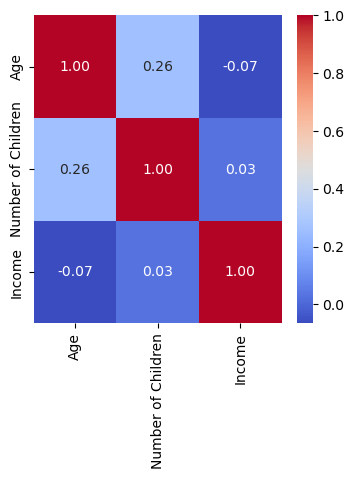

In [16]:
############################################################################################
#   STEP 8 - Feature Engineering: Perform an analysis of correlation
############################################################################################

######### If you skipped Step 7, you can continue here ######################
## While SKIPPING "STEP 7 - Feature Engineering : Creating New Features" STEP

corr_matrix = df[num_cols].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f');

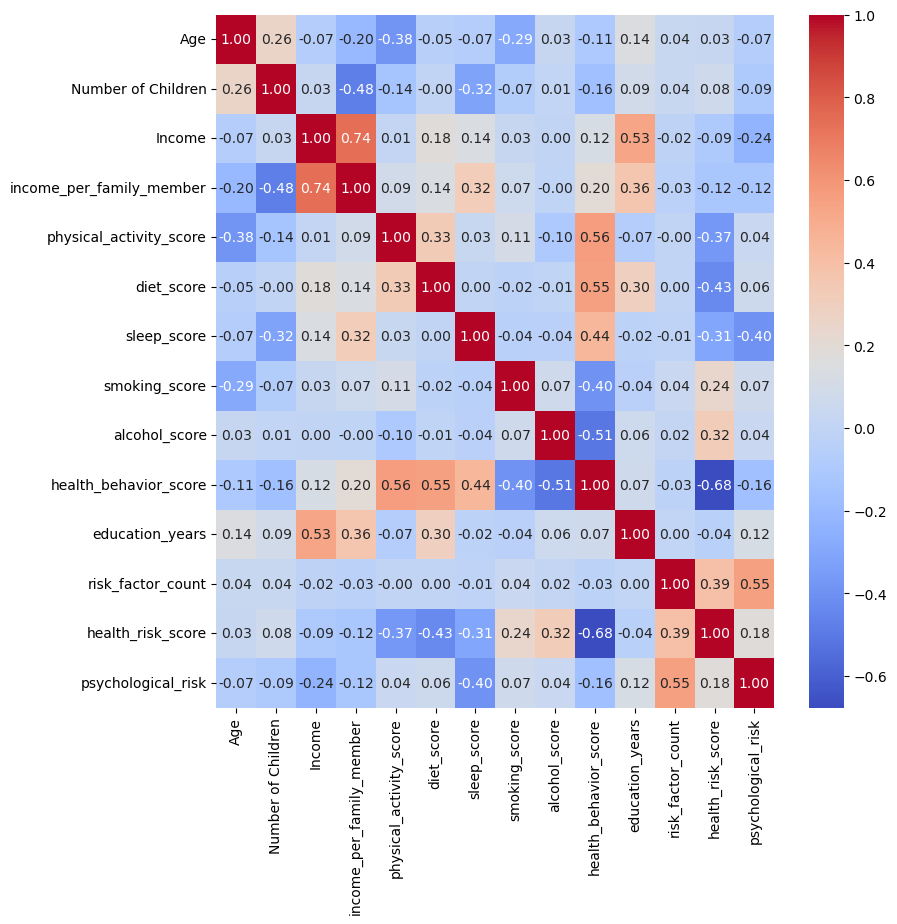

In [16]:
######### If you run Step 7, you can continue here ######################
## WHILE USING "STEP 7 - Feature Engineering : Creating New Features" STEP
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f');

In [ ]:
## Since no significantly correlated features were observed, no feature removal will be performed.

In [ ]:
#########################################################################################################################
#   STEP 9 - Feature Engineering: Dealing with skewed columns => Applying Box-Cox transformation to the shifted values
#########################################################################################################################

## 'Income' column:
#-------------------
# Shows clear right-skewed (positive skew) distribution
# Many people in lower income brackets with a long tail towards higher incomes
# We can apply log transformation to this column (Note: This only would be helpful for distance-based algorithms (KNN, neural networks etc)

           count          mean           std   min       5%     10%        20%        30%        40%        50%        60%        70%        80%         90%         95%         99%        max
Income  413768.0  50661.707971  40624.100565  0.41  4207.07  8428.4  16819.332  24059.472  28994.402  37520.135  47589.584  64369.008  86881.288  106816.921  134446.411  169723.038  209995.22


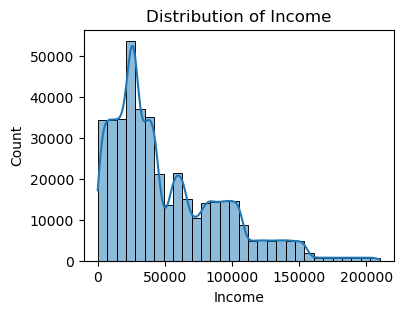

In [10]:
num_summary(df, ['Income'], plot=True)

In [11]:
skewed_cols = ['Income' ]

for col in skewed_cols:
    # Ensure the column has positive values by shifting the data if necessary
    min_value = df[col].min()
    if min_value <= 0:
        # Shift the values so that all are strictly positive
        df[col] = df[col] - min_value + 1
    
    # Apply Box-Cox transformation to the shifted values
    df[col], _ = stats.boxcox(df[col])

           count        mean        std       min         5%       10%        20%        30%         40%         50%         60%        70%         80%         90%         95%        99%         max
Income  413768.0  117.153384  38.932714 -0.764662  51.300106  66.38461  85.550399  97.484111  104.329065  114.561282  124.862071  139.26182  155.167587  167.147198  181.560264  197.40458  213.070712


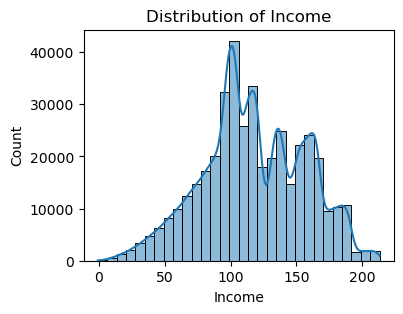

In [12]:
num_summary(df, ['Income'], plot=True)

In [8]:
############################################################################################
#   STEP 10a - Feature Engineering: Encode Categorical Variables
############################################################################################

######### If you skipped Step 7, you can continue here ######################

######### While SKIPPING "Step 7 - FEATURE ENGINEERING: Creating New Features" starts here ############

pd.set_option('display.max_columns', None)
df.head(3)

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No


In [9]:
df.shape ## (413768, 15)

(413768, 15)

In [10]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 413768
Variables: 15
cat_cols: 12
num_cols: 3
cat_but_car: 0
num_but_cat: 0


In [11]:
cat_cols

['Marital Status',
 'Education Level',
 'Smoking Status',
 'Physical Activity Level',
 'Employment Status',
 'Alcohol Consumption',
 'Dietary Habits',
 'Sleep Patterns',
 'History of Mental Illness',
 'History of Substance Abuse',
 'Family History of Depression',
 'Chronic Medical Conditions']

In [12]:
## The one-hot encoder function will transform each class in categorical columns into new features.

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols.remove('History of Mental Illness')

df = one_hot_encoder(df,cat_cols,drop_first=True)

In [13]:
df.shape

(413768, 25)

In [14]:
df.head(2)

,Age,Number of Children,Income,History of Mental Illness,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes
0,31,2,26265.67,Yes,True,False,False,True,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,True
1,55,1,42710.36,Yes,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True


In [15]:
# Move 'History of Mental Illness' to the last column in the dataframe
target_col = 'History of Mental Illness'
df = df[[col for col in df.columns if col != target_col] + [target_col]]

In [16]:
df['History of Mental Illness'] = df['History of Mental Illness'].map({'Yes':1, 'No':0})

In [17]:
df.head(2)  

,Age,Number of Children,Income,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes,History of Mental Illness
0,31,2,26265.67,True,False,False,True,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,True,1
1,55,1,42710.36,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,1


In [18]:
## Mapping of 'True' and 'False' classes in the columns such that True => 1 and False => 0 ##

for col in df.columns:
    if col not in num_cols and col!=['History of Metal Illness']:
        df[col] = df[col].astype(int)

In [19]:
df.head(2) 

,Age,Number of Children,Income,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes,History of Mental Illness
0,31,2,26265.67,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,1
1,55,1,42710.36,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1


In [20]:
## NOTE: LightGBM model gives a warning if there are spaces(' ') in features'/columns' names so we will basically replace them with '_'

for col in df.columns:
    if ' ' in col:
        print(col)

Number of Children
Marital Status_Married
Marital Status_Single
Marital Status_Widowed
Education Level_Bachelor's Degree
Education Level_High School
Education Level_Master's Degree
Education Level_PhD
Smoking Status_Former
Smoking Status_Non-smoker
Physical Activity Level_Moderate
Physical Activity Level_Sedentary
Employment Status_Unemployed
Alcohol Consumption_Low
Alcohol Consumption_Moderate
Dietary Habits_Moderate
Dietary Habits_Unhealthy
Sleep Patterns_Good
Sleep Patterns_Poor
History of Substance Abuse_Yes
Family History of Depression_Yes
Chronic Medical Conditions_Yes
History of Mental Illness


In [21]:
df.columns = df.columns.str.replace(" ", "_") ## Replace them ' ' (spaces) with with '_' in the column's names.

In [ ]:
######### While SKIPPING "Step 7 - FEATURE ENGINEERING: Creating New Features" ends here ############ => GOTO "STEP 11 - MODELING & EVALUATION"

In [15]:
############################################################################################
#   STEP 10b - Feature Engineering: Encode Categorical Variables
############################################################################################
######### If you run Step 7, you can continue here ######################
######### After USING "Step 7 - FEATURE ENGINEERING: Creating New Features" starts here ############

In [16]:
pd.set_option('display.max_columns', None)
df.head(3)

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,age_group,is_retirement_age,life_stage,income_per_family_member,income_bracket,physical_activity_score,diet_score,sleep_score,smoking_score,alcohol_score,health_behavior_score,has_family_support,living_alone,education_years,employment_stress,financial_stress,risk_factor_count,health_risk_score,lifestyle_consistency,psychological_risk
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes,26-35,0,26-35_Married,8755.223333,Low,2,1,1,0,1,7,1,0,16,1,1,2,2,1,2
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes,51-65,0,51-65_Married,21355.180000,Medium,0,0,1,0,2,3,1,0,12,0,0,1,5,0,0
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No,65+,1,65+_Widowed,62666.395000,Very High,0,0,2,0,0,6,1,0,18,0,0,1,2,0,1


In [17]:
df.shape ## (413768, 35)

(413768, 35)

In [18]:
cat_cols

['Marital Status',
 'Education Level',
 'Smoking Status',
 'Physical Activity Level',
 'Employment Status',
 'Alcohol Consumption',
 'Dietary Habits',
 'Sleep Patterns',
 'History of Mental Illness',
 'History of Substance Abuse',
 'Family History of Depression',
 'Chronic Medical Conditions',
 'age_group',
 'life_stage',
 'income_bracket']

In [19]:
## The one-hot encoder function will transform each class in categorical columns into new features.

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols.remove('History of Mental Illness')

df = one_hot_encoder(df,cat_cols,drop_first=True)

In [20]:
df.shape

(413768, 63)

In [21]:
df.head(2)

,Age,Number of Children,Income,History of Mental Illness,is_retirement_age,income_per_family_member,physical_activity_score,diet_score,sleep_score,smoking_score,alcohol_score,health_behavior_score,has_family_support,living_alone,education_years,employment_stress,financial_stress,risk_factor_count,health_risk_score,lifestyle_consistency,psychological_risk,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes,age_group_26-35,age_group_36-50,age_group_51-65,age_group_65+,life_stage_18-25_Single,life_stage_26-35_Divorced,life_stage_26-35_Married,life_stage_26-35_Single,life_stage_36-50_Divorced,life_stage_36-50_Married,life_stage_36-50_Single,life_stage_36-50_Widowed,life_stage_51-65_Divorced,life_stage_51-65_Married,life_stage_51-65_Widowed,life_stage_65+_Married,life_stage_65+_Widowed,income_bracket_Low,income_bracket_Medium,income_bracket_High,income_bracket_Very High
0,31,2,26265.67,Yes,0,8755.223333,2,1,1,0,1,7,1,0,16,1,1,2,2,1,2,True,False,False,True,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,55,1,42710.36,Yes,0,21355.180000,0,0,1,0,2,3,1,0,12,0,0,1,5,0,0,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False


In [22]:
# Move 'History of Mental Illness' to the last column in the dataframe
target_col = 'History of Mental Illness'
df = df[[col for col in df.columns if col != target_col] + [target_col]]

In [23]:
df['History of Mental Illness'] = df['History of Mental Illness'].map({'Yes':1, 'No':0})

In [24]:
df.head(2)

,Age,Number of Children,Income,is_retirement_age,income_per_family_member,physical_activity_score,diet_score,sleep_score,smoking_score,alcohol_score,health_behavior_score,has_family_support,living_alone,education_years,employment_stress,financial_stress,risk_factor_count,health_risk_score,lifestyle_consistency,psychological_risk,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes,age_group_26-35,age_group_36-50,age_group_51-65,age_group_65+,life_stage_18-25_Single,life_stage_26-35_Divorced,life_stage_26-35_Married,life_stage_26-35_Single,life_stage_36-50_Divorced,life_stage_36-50_Married,life_stage_36-50_Single,life_stage_36-50_Widowed,life_stage_51-65_Divorced,life_stage_51-65_Married,life_stage_51-65_Widowed,life_stage_65+_Married,life_stage_65+_Widowed,income_bracket_Low,income_bracket_Medium,income_bracket_High,income_bracket_Very High,History of Mental Illness
0,31,2,26265.67,0,8755.223333,2,1,1,0,1,7,1,0,16,1,1,2,2,1,2,True,False,False,True,False,False,False,False,True,False,False,True,False,True,True,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,1
1,55,1,42710.36,0,21355.180000,0,0,1,0,2,3,1,0,12,0,0,1,5,0,0,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,1


In [25]:
## Mapping of 'True' and 'False' classes in the columns such that True => 1 and False => 0 ##

for col in df.columns:
    if col not in num_cols and col!=['History of Metal Illness']:
        df[col] = df[col].astype(int)

In [26]:
df.head(2) 

,Age,Number of Children,Income,is_retirement_age,income_per_family_member,physical_activity_score,diet_score,sleep_score,smoking_score,alcohol_score,health_behavior_score,has_family_support,living_alone,education_years,employment_stress,financial_stress,risk_factor_count,health_risk_score,lifestyle_consistency,psychological_risk,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's Degree,Education Level_PhD,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Employment Status_Unemployed,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes,age_group_26-35,age_group_36-50,age_group_51-65,age_group_65+,life_stage_18-25_Single,life_stage_26-35_Divorced,life_stage_26-35_Married,life_stage_26-35_Single,life_stage_36-50_Divorced,life_stage_36-50_Married,life_stage_36-50_Single,life_stage_36-50_Widowed,life_stage_51-65_Divorced,life_stage_51-65_Married,life_stage_51-65_Widowed,life_stage_65+_Married,life_stage_65+_Widowed,income_bracket_Low,income_bracket_Medium,income_bracket_High,income_bracket_Very High,History of Mental Illness
0,31,2,26265.67,0,8755.223333,2,1,1,0,1,7,1,0,16,1,1,2,2,1,2,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,55,1,42710.36,0,21355.180000,0,0,1,0,2,3,1,0,12,0,0,1,5,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [27]:
## NOTE: LightGBM model gives a warning if there are spaces(' ') in features'/columns' names so we will basically replace them with '_'

for col in df.columns:
    if ' ' in col:
        print(col)

Number of Children
Marital Status_Married
Marital Status_Single
Marital Status_Widowed
Education Level_Bachelor's Degree
Education Level_High School
Education Level_Master's Degree
Education Level_PhD
Smoking Status_Former
Smoking Status_Non-smoker
Physical Activity Level_Moderate
Physical Activity Level_Sedentary
Employment Status_Unemployed
Alcohol Consumption_Low
Alcohol Consumption_Moderate
Dietary Habits_Moderate
Dietary Habits_Unhealthy
Sleep Patterns_Good
Sleep Patterns_Poor
History of Substance Abuse_Yes
Family History of Depression_Yes
Chronic Medical Conditions_Yes
income_bracket_Very High
History of Mental Illness


In [28]:
df.columns = df.columns.str.replace(" ", "_") ## Replace them ' ' (spaces) with with '_' in the column's names.

In [ ]:
######### After USING "Step 7 - FEATURE ENGINEERING: Creating New Features" ends here ############ => GOTO "STEP 11 - MODELING & EVALUATION"

In [22]:
############################################################################################
#   STEP 11 - MODELING & EVALUATION
############################################################################################
y = df['History_of_Mental_Illness']
X = df.drop(['History_of_Mental_Illness'], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25, stratify=y)

In [ ]:
############################################################################################
#   STEP 12 -  Standardisation
############################################################################################
# It is very important to apply standardisation after splitting the dataset into training and test sets to avoid data leakage.
# We do not need to use this operation while using tree based ML models (Randon Forest etc..) 
# Large differences in numeric columns values cause bias while using distance-based ML models such as KNN, KMeans or PCA.
# Robust scaler (RobustScaler()) is more resilient to the outliers compared to Min_Max and Standard_Scale.

In [27]:
rs = RobustScaler()

# Fit the scaler on the training set and transform the training data
X_train_scaled = rs.fit_transform(X_train)

# Use the fitted scaler to transform the test set (without fitting it again)
X_test_scaled = rs.transform(X_test)

## Delete old datasets
del X_train, X_test

### Assign the scaled ones to the variables
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
################## STEP 13 - MODEL'S EVALUATION  ######################

In [33]:
################## HANDLING IMBALANCED DATASET ########################

# If we look at our TARGET VARIABLE distribution, we notice that we have moderate imbalanced dataset:
# No (Negative class): 287,943 cases (69.6%)
# Yes (Positive class): 125,825 cases (30.4%)

# Our imbalance ratio of approximately [2.3:1]
# With this distribution the PR-AUC BASELINE would be around 0.304 (30.4%)

# We will use standard metrics like ROC-AUC alongside PR-AUC (Precision Recall Area Under Curve)
# We will try various techniques:

#1) Class weights in the model (about 2.3 weight for positive class)
#2) Basic resampling if needed
#3) Regular cross-validation with stratification

In [25]:
# All classification models to be used

models = [('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=33)),
          ('RF', RandomForestClassifier(random_state=33)),
          ('GBM', GradientBoostingClassifier(random_state=33)),
          ('LightGBM', LGBMClassifier(verbose=-1, random_state=33)),
         ('CatBoost', CatBoostClassifier(verbose=False, random_state=33)),
          ('Logistic Regression', LogisticRegression(random_state=33)),
          ('XG Boost', XGBClassifier(random_state=33))]


In [35]:
Counter(y_train), Counter(y_test)

(Counter({0: 230354, 1: 100660}), Counter({0: 57589, 1: 25165}))

In [38]:
### 1) FIRST ATTEMPT with the following options:
### APPLIED ? => Standardisation (Step 12): NO / Skewness Handling (Step 9): NO / Feature engineering (Step 7): NO

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    avg_p_score = average_precision_score(y_test, y_pred_prob)
    msg = "Accuracy of %s: (%.2f) - AUROC: %.2f - PR-AUC: %.2f" % (name, acc, roc_auc, avg_p_score)
    print(msg)
    print(classification_report(y_test, y_pred))

Accuracy of KNN: (0.64) - AUROC: 0.53 - PR-AUC: 0.32
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     57589
           1       0.34      0.20      0.25     25165

    accuracy                           0.64     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.64      0.61     82754

Accuracy of CART: (0.58) - AUROC: 0.51 - PR-AUC: 0.31
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     57589
           1       0.32      0.34      0.33     25165

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.58     82754

Accuracy of RF: (0.66) - AUROC: 0.55 - PR-AUC: 0.34
              precision    recall  f1-score   support

           0       0.70      0.88      0.78     57589
           1       0.35      0.15      0.21     25165

    accuracy           

C:\Users\ser_k\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ser_k\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ser_k\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy of XG Boost: (0.69) - AUROC: 0.59 - PR-AUC: 0.37
              precision    recall  f1-score   support

           0       0.70      0.99      0.82     57589
           1       0.35      0.01      0.02     25165

    accuracy                           0.69     82754
   macro avg       0.52      0.50      0.42     82754
weighted avg       0.59      0.69      0.57     82754



In [44]:
### 2) SECOND ATTEMPT using CLASS WEIGHTS to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: NO

## We notice above the warning from the Logistic Regression Model due to the minority class (class 1) was never predicted by the model.
## This happens when the model fails to predict certain labels, leading to undefined precision for those classes.
## It occurs when  the dataset is imbalanced (one class is much more frequent than the other like class 0 in the dataset).

## So we will use "class weighting='balanced'" parameter to help the models learn from the minority class.
## This will give more weight to the minority class and help the model predict it better.

## There is no class weight option for KNN and GBM so we will remove them from the list


fraud_weight = sum(y_train == 0) / sum(y_train == 1)  ## Required for XGBoost : compute weight as (non-fraud samples / fraud samples)

models = [('CART', DecisionTreeClassifier(class_weight='balanced', random_state=33)),
          ('RF', RandomForestClassifier(class_weight='balanced', random_state=33)),
          ('LightGBM', LGBMClassifier(class_weight='balanced', verbose=-1, random_state=33)),
         ('CatBoost', CatBoostClassifier(auto_class_weights='Balanced', verbose=False, random_state=33)),
          ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=33)),
          ('XG Boost', XGBClassifier(scale_pos_weight=fraud_weight, random_state=33))]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    avg_p_score = average_precision_score(y_test, y_pred_prob)
    msg = "Accuracy of %s: (%f) - AUROC: %f - PR-AUC: %f" % (name, acc, roc_auc, avg_p_score)
    print(msg)
    print(classification_report(y_test, y_pred))


Accuracy of CART: (0.586280) - AUROC: 0.511802 - PR-AUC: 0.309358
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     57589
           1       0.32      0.32      0.32     25165

    accuracy                           0.59     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.59      0.59     82754

Accuracy of RF: (0.659847) - AUROC: 0.552790 - PR-AUC: 0.336660
              precision    recall  f1-score   support

           0       0.70      0.89      0.78     57589
           1       0.35      0.14      0.20     25165

    accuracy                           0.66     82754
   macro avg       0.53      0.51      0.49     82754
weighted avg       0.60      0.66      0.61     82754

Accuracy of LightGBM: (0.583259) - AUROC: 0.597224 - PR-AUC: 0.367390
              precision    recall  f1-score   support

           0       0.75      0.60      0.67     57589
           1       0.37      0.55    

In [46]:
### 3) THIRD ATTEMPT using RandomOverSampler to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: NO

Counter(y_train)

Counter({0: 230354, 1: 100660})

In [38]:
models = [('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=33)),
          ('RF', RandomForestClassifier(random_state=33)),
          ('GBM', GradientBoostingClassifier(random_state=33)),
          ('LightGBM', LGBMClassifier(verbose=-1, random_state=33)),
         ('CatBoost', CatBoostClassifier(verbose=False, random_state=33)),
          ('Logistic Regression', LogisticRegression(random_state=33)),
          ('XG Boost', XGBClassifier(random_state=33))]

In [50]:
oversampler = RandomOverSampler(random_state=33)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

In [51]:
Counter(y_train_over) ## All classes are balanced at 230354.

Counter({0: 230354, 1: 230354})

In [54]:
for name, model in models:
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    avg_p_score = average_precision_score(y_test, y_pred_prob)
    msg = "Accuracy of %s: (%.2f) - AUROC: %.2f - PR-AUC: %.2f" % (name, acc, roc_auc, avg_p_score)
    print(msg)
    print(classification_report(y_test, y_pred))

Accuracy of KNN: (0.54) - AUROC: 0.53 - PR-AUC: 0.32
              precision    recall  f1-score   support

           0       0.71      0.56      0.63     57589
           1       0.32      0.48      0.39     25165

    accuracy                           0.54     82754
   macro avg       0.52      0.52      0.51     82754
weighted avg       0.59      0.54      0.56     82754

Accuracy of CART: (0.59) - AUROC: 0.51 - PR-AUC: 0.31
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     57589
           1       0.32      0.33      0.33     25165

    accuracy                           0.59     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.59      0.59     82754

Accuracy of RF: (0.63) - AUROC: 0.55 - PR-AUC: 0.33
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     57589
           1       0.35      0.25      0.29     25165

    accuracy           

In [66]:
### 4) FOURTH ATTEMPT using SMOTE (Synthetic Minority Over-sampling Technique) to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: NO
Counter(y_train)

Counter({0: 230354, 1: 100660})

In [67]:
smote = SMOTE(sampling_strategy='auto',random_state=33)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) 

In [69]:
Counter(y_train_smote) ## The minority class is oversampled and all classes are balanced at 230354.

Counter({0: 230354, 1: 230354})

In [70]:
for name, model in models:
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    avg_p_score = average_precision_score(y_test, y_pred_prob)
    msg = "Accuracy of %s: (%.2f) - AUROC: %.2f - PR-AUC: %.2f" % (name, acc, roc_auc, avg_p_score)
    print(msg)
    print(classification_report(y_test, y_pred))

Accuracy of KNN: (0.53) - AUROC: 0.53 - PR-AUC: 0.32
              precision    recall  f1-score   support

           0       0.72      0.52      0.61     57589
           1       0.33      0.53      0.40     25165

    accuracy                           0.53     82754
   macro avg       0.52      0.53      0.50     82754
weighted avg       0.60      0.53      0.54     82754

Accuracy of CART: (0.52) - AUROC: 0.51 - PR-AUC: 0.31
              precision    recall  f1-score   support

           0       0.71      0.52      0.60     57589
           1       0.32      0.51      0.39     25165

    accuracy                           0.52     82754
   macro avg       0.51      0.51      0.49     82754
weighted avg       0.59      0.52      0.53     82754

Accuracy of RF: (0.54) - AUROC: 0.55 - PR-AUC: 0.34
              precision    recall  f1-score   support

           0       0.73      0.54      0.62     57589
           1       0.34      0.53      0.41     25165

    accuracy           

In [34]:
### 5) FIFTH ATTEMPT using RandomUnderSampler to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: NO

Counter(y_train)

Counter({0: 230354, 1: 100660})

In [35]:
undersampler = RandomUnderSampler(random_state=33)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

In [36]:
Counter(y_train_under) ## The majority class is undersampled to 100660.

Counter({0: 100660, 1: 100660})

In [39]:
for name, model in models:
    model.fit(X_train_under, y_train_under)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    avg_p_score = average_precision_score(y_test, y_pred_prob)
    msg = "Accuracy of %s: (%.2f) - AUROC: %.2f - PR-AUC: %.2f" % (name, acc, roc_auc, avg_p_score)
    print(msg)
    print(classification_report(y_test, y_pred))

Accuracy of KNN: (0.52) - AUROC: 0.53 - PR-AUC: 0.32
              precision    recall  f1-score   support

           0       0.72      0.52      0.61     57589
           1       0.33      0.52      0.40     25165

    accuracy                           0.52     82754
   macro avg       0.52      0.52      0.50     82754
weighted avg       0.60      0.52      0.54     82754

Accuracy of CART: (0.52) - AUROC: 0.51 - PR-AUC: 0.31
              precision    recall  f1-score   support

           0       0.71      0.52      0.60     57589
           1       0.32      0.51      0.39     25165

    accuracy                           0.52     82754
   macro avg       0.51      0.51      0.49     82754
weighted avg       0.59      0.52      0.54     82754

Accuracy of RF: (0.54) - AUROC: 0.55 - PR-AUC: 0.34
              precision    recall  f1-score   support

           0       0.73      0.54      0.62     57589
           1       0.34      0.54      0.42     25165

    accuracy           

In [30]:
### 6) SIXTH ATTEMPT using StratifiedKFold cross-validation technique to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: YES

In [33]:
def evaluate_models(X, y, n_splits=5):
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y
    
    # Define models
    models = {
        'KNN': KNeighborsClassifier(),
        'CART': DecisionTreeClassifier(random_state=33),
        'RF': RandomForestClassifier(random_state=33),
        'GBM': GradientBoostingClassifier(random_state=33),
        'LightGBM': LGBMClassifier(random_state=33),
        'CatBoost': CatBoostClassifier(verbose=False, random_state=33),
        'LogisticRegression': LogisticRegression(random_state=33),
        'XGBoost': XGBClassifier(random_state=33)
    }
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)
    
    results = []
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        auroc_scores = []
        pr_auc_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict_proba(X_val)[:, 1]
            
            auroc = roc_auc_score(y_val, y_pred)
            pr_auc = average_precision_score(y_val, y_pred)
            
            auroc_scores.append(auroc)
            pr_auc_scores.append(pr_auc)
            
            print(f"Fold {fold} - AUROC: {auroc:.4f}, PR-AUC: {pr_auc:.4f}")
      
        mean_auroc = np.mean(auroc_scores)
        mean_pr_auc = np.mean(pr_auc_scores)
    
        results.append({
            'Model': name,
            'AUROC': f"{mean_auroc:.4f}",
            'PR-AUC': f"{mean_pr_auc:.4f}"
        })
    
    return pd.DataFrame(results)

In [34]:
results = evaluate_models(X, y)

print("\nFinal Results:")
print(results.sort_values('PR-AUC', ascending=False))


Training KNN...
Fold 1 - AUROC: 0.5287, PR-AUC: 0.3200
Fold 2 - AUROC: 0.5329, PR-AUC: 0.3221
Fold 3 - AUROC: 0.5295, PR-AUC: 0.3206
Fold 4 - AUROC: 0.5332, PR-AUC: 0.3228
Fold 5 - AUROC: 0.5310, PR-AUC: 0.3215

Training CART...
Fold 1 - AUROC: 0.5152, PR-AUC: 0.3109
Fold 2 - AUROC: 0.5154, PR-AUC: 0.3111
Fold 3 - AUROC: 0.5103, PR-AUC: 0.3087
Fold 4 - AUROC: 0.5172, PR-AUC: 0.3119
Fold 5 - AUROC: 0.5131, PR-AUC: 0.3099

Training RF...
Fold 1 - AUROC: 0.5511, PR-AUC: 0.3347
Fold 2 - AUROC: 0.5510, PR-AUC: 0.3358
Fold 3 - AUROC: 0.5510, PR-AUC: 0.3341
Fold 4 - AUROC: 0.5520, PR-AUC: 0.3364
Fold 5 - AUROC: 0.5503, PR-AUC: 0.3355

Training GBM...
Fold 1 - AUROC: 0.5989, PR-AUC: 0.3700
Fold 2 - AUROC: 0.5998, PR-AUC: 0.3711
Fold 3 - AUROC: 0.5966, PR-AUC: 0.3695
Fold 4 - AUROC: 0.5980, PR-AUC: 0.3695
Fold 5 - AUROC: 0.6005, PR-AUC: 0.3713

Training LightGBM...
Fold 1 - AUROC: 0.5993, PR-AUC: 0.3696
Fold 2 - AUROC: 0.6004, PR-AUC: 0.3723
Fold 3 - AUROC: 0.5958, PR-AUC: 0.3692
Fold 4 - AURO

In [ ]:
### 7) SEVEN ATTEMPT using StratifiedKFold cross-validation technique to handle IMBALANCED DATA with the following options:
### Standardisation: NO / Skewness Handling: NO / Feature engineering: NO

In [23]:
def evaluate_models(X, y, n_splits=5):
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y
    
    models = {
        'KNN': KNeighborsClassifier(),
        'CART': DecisionTreeClassifier(random_state=33),
        'RF': RandomForestClassifier(random_state=33),
        'GBM': GradientBoostingClassifier(random_state=33),
        'LightGBM': LGBMClassifier(verbose=-1, random_state=33),
        'CatBoost': CatBoostClassifier(verbose=False, random_state=33),
        'LogisticRegression': LogisticRegression(random_state=33),
        'XGBoost': XGBClassifier(random_state=33)
    }
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)
    
    results = []
    best_model = None
    best_auroc = -np.inf
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        auroc_scores = []
        pr_auc_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict_proba(X_val)[:, 1]
            
            auroc = roc_auc_score(y_val, y_pred)
            pr_auc = average_precision_score(y_val, y_pred)
            
            auroc_scores.append(auroc)
            pr_auc_scores.append(pr_auc)
            
            print(f"Fold {fold} - AUROC: {auroc:.4f}, PR-AUC: {pr_auc:.4f}")
      
        mean_auroc = np.mean(auroc_scores)
        mean_pr_auc = np.mean(pr_auc_scores)
    
        results.append({
            'Model': name,
            'AUROC': f"{mean_auroc:.4f}",
            'PR-AUC': f"{mean_pr_auc:.4f}"
        })

        if mean_auroc > best_auroc:
            best_auroc = mean_auroc
            best_model = model
            
    results_df = pd.DataFrame(results)
    return results_df

In [24]:
results = evaluate_models(X, y)

print("\nFinal Results:")
print(results.sort_values('PR-AUC', ascending=False))


Training KNN...
Fold 1 - AUROC: 0.5277, PR-AUC: 0.3195
Fold 2 - AUROC: 0.5325, PR-AUC: 0.3225
Fold 3 - AUROC: 0.5287, PR-AUC: 0.3212
Fold 4 - AUROC: 0.5349, PR-AUC: 0.3240
Fold 5 - AUROC: 0.5308, PR-AUC: 0.3215

Training CART...
Fold 1 - AUROC: 0.5136, PR-AUC: 0.3102
Fold 2 - AUROC: 0.5133, PR-AUC: 0.3100
Fold 3 - AUROC: 0.5122, PR-AUC: 0.3095
Fold 4 - AUROC: 0.5111, PR-AUC: 0.3090
Fold 5 - AUROC: 0.5145, PR-AUC: 0.3106

Training RF...
Fold 1 - AUROC: 0.5497, PR-AUC: 0.3344
Fold 2 - AUROC: 0.5523, PR-AUC: 0.3369
Fold 3 - AUROC: 0.5523, PR-AUC: 0.3364
Fold 4 - AUROC: 0.5531, PR-AUC: 0.3387
Fold 5 - AUROC: 0.5513, PR-AUC: 0.3370

Training GBM...
Fold 1 - AUROC: 0.5999, PR-AUC: 0.3707
Fold 2 - AUROC: 0.6008, PR-AUC: 0.3711
Fold 3 - AUROC: 0.5968, PR-AUC: 0.3696
Fold 4 - AUROC: 0.5989, PR-AUC: 0.3707
Fold 5 - AUROC: 0.6009, PR-AUC: 0.3719

Training LightGBM...
Fold 1 - AUROC: 0.5997, PR-AUC: 0.3705
Fold 2 - AUROC: 0.6012, PR-AUC: 0.3720
Fold 3 - AUROC: 0.5979, PR-AUC: 0.3727
Fold 4 - AURO

Original shape: (413768, 24), Resampled shape: (575886, 24)
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[470]	valid_0's auc: 0.808104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.806155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's auc: 0.808831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.80726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid_0's auc: 0.807179
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79    287943
           1       0.89      0.57      0.70    287943

    accuracy                           0.75    575886
   macro avg       0.79      0.75      0.74    575886
wei

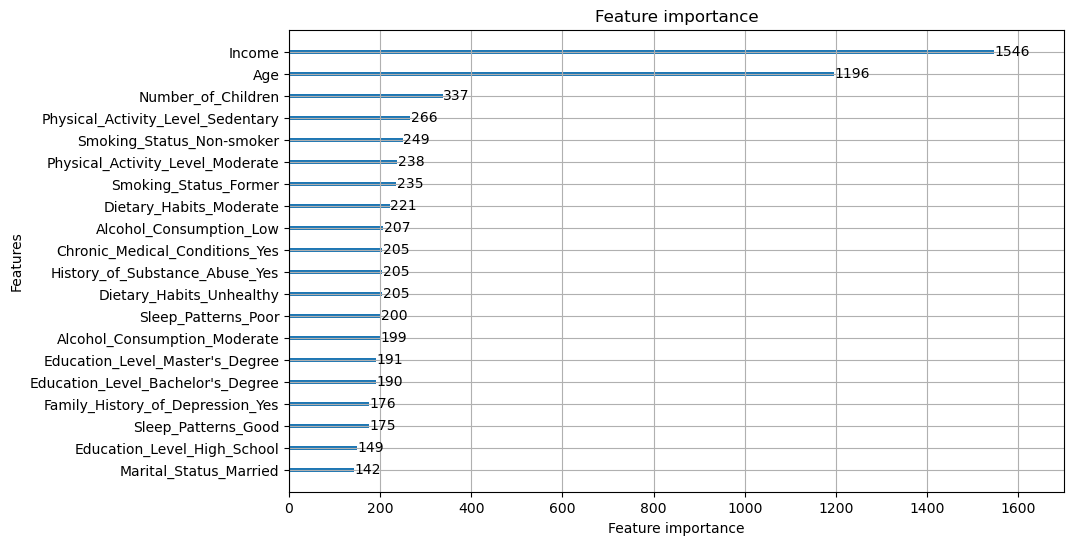

Model saved as 'lightgbm_model.pkl'


In [31]:
#########################################################################################################################################
#                                                   FINAL MODEL & FEATURE IMPORTANCE
#          Using LightGBM + SMOTE + StratifiedKFold cross-validation technique + Hyperparameters tuning to handle IMBALANCED DATA
#          with the following options:
#                                Standardisation: NO / Skewness Handling: NO / Feature engineering: NO
#########################################################################################################################################

smote = SMOTE(sampling_strategy='minority', random_state=33)
X_res, y_res = smote.fit_resample(X, y)

print(f"Original shape: {X.shape}, Resampled shape: {X_res.shape}")

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": 33,
    "is_unbalance": True  
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

X_res = np.array(X_res)
y_res = np.array(y_res)

oof_preds = np.zeros(X_res.shape[0]) 
oof_preds_bin = np.zeros(X_res.shape[0])  

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_res, y_res)):
    X_train, X_valid = X_res[train_idx], X_res[valid_idx]
    y_train, y_valid = y_res[train_idx], y_res[valid_idx]
    
    train_set = lgb.Dataset(X_train, label=y_train, feature_name=X.columns.tolist())
    valid_set = lgb.Dataset(X_valid, label=y_valid, reference=train_set, feature_name=X.columns.tolist())
    
    early_stopping = lgb.early_stopping(stopping_rounds=50)

    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        num_boost_round=500,
        callbacks=[early_stopping],
    )
    
    oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_preds_bin[valid_idx] = (oof_preds[valid_idx] > 0.5).astype(int)  


print("Classification Report:")
print(classification_report(y_res, oof_preds_bin))

pr_auc = average_precision_score(y_res, oof_preds)
print(f"PR-AUC: {pr_auc:.4f}")

lgb.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.show()

with open('lightgbm_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'lightgbm_model.pkl'")
